# AR3 Model Fitting and Forecasting

### Importing Required Libraries

In [22]:
from typing import Any, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm, uniform
from scipy.optimize import minimize
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_process import arma_acovf

### Part I: Identifying the Best ARMA Model

We will be using arma_data.csv in this notebook. We believe that this data comes from a stationary process, and we would like to model the data as ARMA(p,q). The question is what the correct value of p and q are for this process. Using the ACF and PACF, we attempt to find the right values of p and q for the given dataset.

In [23]:
df = pd.read_csv("arma_data.csv")
time = np.array(df['time'])
signal = np.array(df['signal'])

In [24]:
n_lags = 20
acf_estimate = acf(signal, nlags=n_lags, fft=False) 
pacf_estimate = pacf(signal, nlags=n_lags, method="ywmle")     

N = len(signal)
z = 2

acf_error_estimate  = z / np.sqrt(N)
pacf_error_estimate = z / np.sqrt(N)

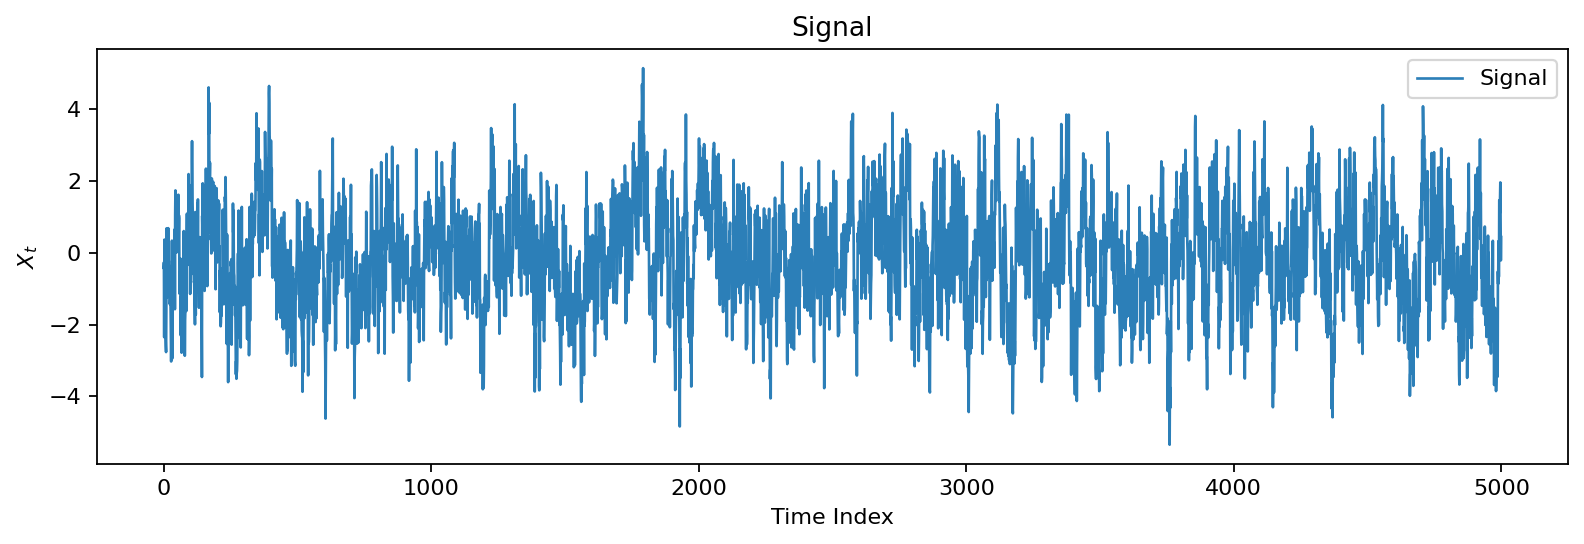

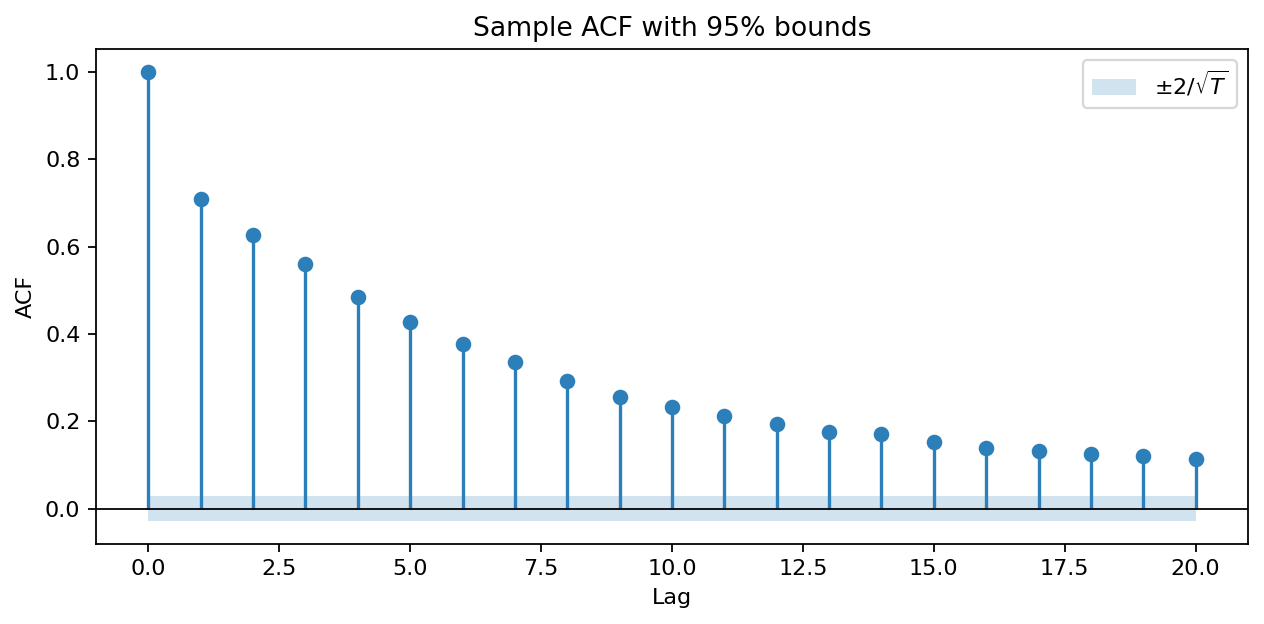

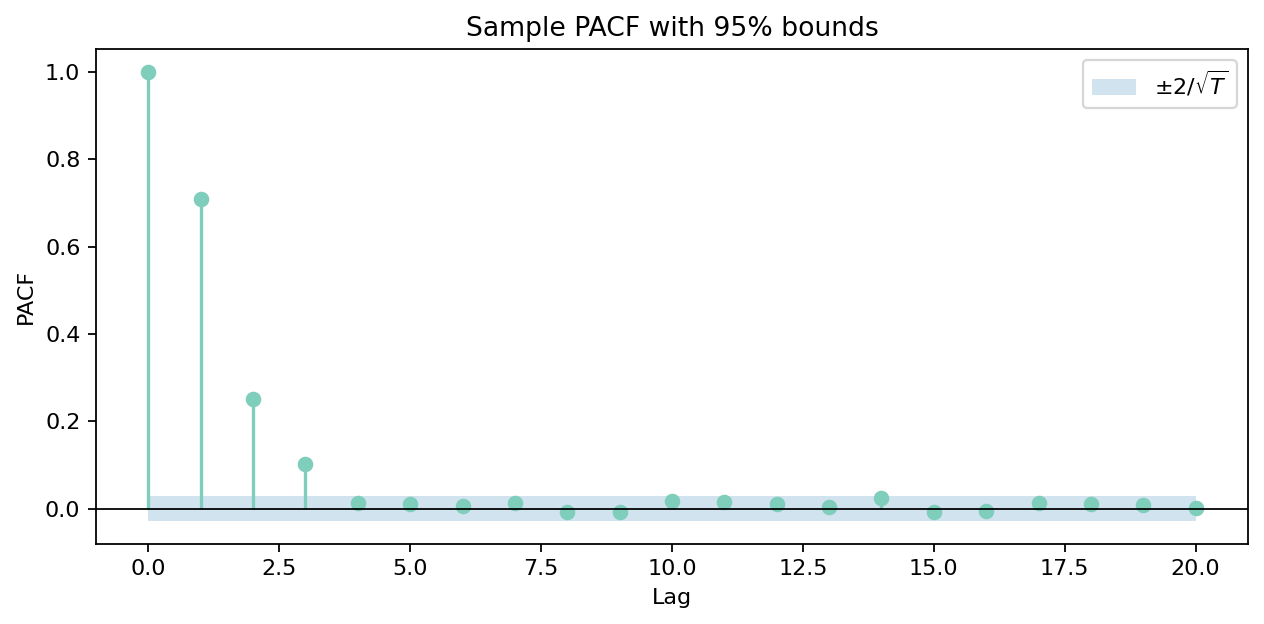

In [25]:
colors = ['#7fcdbb', '#2c7fb8']  # data / stems
band = acf_error_estimate
lags = np.arange(n_lags + 1)

# 1) Raw data
fig, ax = plt.subplots(figsize=(10, 3.5), dpi=160)
ax.plot(time, signal, lw=1.2, color=colors[1], label='Signal')
ax.set_title('Signal')
ax.set_xlabel('Time Index')
ax.set_ylabel(r'$X_t$')
ax.legend()
plt.tight_layout()
plt.show()

# 2) ACF with ±2/√T band
fig, ax = plt.subplots(figsize=(8, 4), dpi=160)
markerline, stemlines, baseline = ax.stem(lags, acf_estimate, basefmt='k')
markerline.set_color(colors[1])
try:
    stemlines.set_color(colors[1])       
except AttributeError:
    import matplotlib.pyplot as plt
    plt.setp(stemlines, color=colors[1]) 
baseline.set_visible(False)
ax.fill_between(lags, -band, band, alpha=0.20, label=r'$\pm 2/\sqrt{T}$')
ax.axhline(0, color='k', lw=0.8)
ax.set_title('Sample ACF with 95% bounds')
ax.set_xlabel('Lag')
ax.set_ylabel('ACF')
ax.legend()
plt.tight_layout()
plt.show()

# 3) PACF with ±2/√T band
fig, ax = plt.subplots(figsize=(8, 4), dpi=160)
markerline, stemlines, baseline = ax.stem(lags, pacf_estimate, basefmt='k')
markerline.set_color(colors[0])
try:
    stemlines.set_color(colors[0])
except AttributeError:
    import matplotlib.pyplot as plt
    plt.setp(stemlines, color=colors[0])
baseline.set_visible(False)
ax.fill_between(lags, -band, band, alpha=0.20, label=r'$\pm 2/\sqrt{T}$')
ax.axhline(0, color='k', lw=0.8)
ax.set_title('Sample PACF with 95% bounds')
ax.set_xlabel('Lag')
ax.set_ylabel('PACF')
ax.legend()
plt.tight_layout()
plt.show()

The ACF decays gradually toward zero without a sharp cutoff, and the PACF plot shows a sharp cutoff at lag *p* (to be determined), which is characteristic of an autoregressive (AR) process rather than a moving average (MA) process. This suggests that *q = 0*.

To determine the order *p*, we examine the PACF plot. The PACF displays three clearly significant spikes at lags 1 to 3, while all subsequent lags fall within the 95% confidence bounds (± 2/√T), indicating they are not statistically significant. This pattern, PACF cutting off after lag 3, is characteristic of an AR(3) process (*p = 3*). The data also look stationary (roughly constant mean/variance), consistent with fitting an AR(3).

**Conclusion:** The process can be modeled as an **AR(3)**, i.e., an **ARMA(3, 0)** model.

### Part II: Fitting our AR(3) Model

Now, it's time to fit the data to an AR(3) model.To do this you will have to:

1. **Calculate the posterior** for the parameters of an **AR(3)** process.  
2. **Calculate the conditional distribution** for an **AR(3)** process given its parameters.  
3. **Plot samples and the conditional distribution** for our **AR(3)** process.

In [26]:
class ARThreeModel:
    """Class implementing prior, likelihood, posterior, and predictions for an 
    AR(3) model.

    Args:
        sigma_phi: Sigma for the prior on parameters phi_1, phi_2, and phi_3.
        sigma_max: Maximum value for uniform prior on sigma_w.
    """

    def __init__(self, sigma_phi: float, sigma_max: float):
        self.sigma_phi = float(sigma_phi)  
        self.sigma_max = float(sigma_max)  

    def log_prior(self, params):
        phi1, phi2, phi3, sigma_w = [float(v) for v in params]
        s2 = self.sigma_phi ** 2

        # Gaussian priors on phi's
        logN_phi1 = -0.5*np.log(2*np.pi*s2) - 0.5*(phi1**2)/s2
        logN_phi2 = -0.5*np.log(2*np.pi*s2) - 0.5*(phi2**2)/s2
        logN_phi3 = -0.5*np.log(2*np.pi*s2) - 0.5*(phi3**2)/s2

        # Uniform prior on sigma_w
        if 0.0 < sigma_w <= self.sigma_max:
            logU = -np.log(self.sigma_max)
        else:
            return -np.inf

        return logN_phi1 + logN_phi2 + logN_phi3 + logU
    
    def log_likelihood(self, x, params):
        x = np.asarray(x, dtype=float).ravel()
        phi1, phi2, phi3, sigma_w = [float(v) for v in params]
        s2 = sigma_w**2
        const = -0.5 * np.log(2 * np.pi * s2)

        # t = 0 
        ll = const - 0.5 * (x[0]**2) / s2

        # t = 1 
        mean_1 = phi1 * x[0]
        ll += const - 0.5 * ((x[1] - mean_1)**2) / s2

        # t = 2 
        mean_2 = phi1 * x[1] + phi2 * x[0]
        ll += const - 0.5 * ((x[2] - mean_2)**2) / s2

        # t >= 3 
        for t in range(3, len(x)):
            mean_t = phi1 * x[t-1] + phi2 * x[t-2] + phi3 * x[t-3]
            ll += const - 0.5 * ((x[t] - mean_t)**2) / s2

        return ll
    
    def log_posterior(self, params, x):
        lp = self.log_prior(params)

        if not np.isfinite(lp):
            return -np.inf
        
        return lp + self.log_likelihood(x, params)

Let’s run some tests to make sure the implementations are correct.

In [27]:
a_model = ARThreeModel(2.0, 5.0)

phi_one, phi_two, phi_three = 0.5, 0.2, 0.1
sigma_w = 1.0
params_test = np.array([phi_one, phi_two, phi_three, sigma_w])
x_t = np.array([3.52810469, 3.2699877, 4.9520883, 8.60224575, 10.74710566, 
                7.28886735, 9.15180511, 7.56132263, 6.91684916, 7.17525595])

np.testing.assert_almost_equal(a_model.log_prior([0.3, 0.4, 0.5, 2.0]), 
                               -6.508195053727955)
np.testing.assert_almost_equal(a_model.log_prior([0.3, 0.4, 0.5, 6.0]), 
                               -np.inf)
np.testing.assert_almost_equal(a_model.log_likelihood(x_t, params_test), 
                               -50.47684010239573)
np.testing.assert_almost_equal(a_model.log_posterior(params_test, x_t), 
                               -56.96003515612368)

Now, let’s fit our model to the data using the priors.

In [28]:
# Instantiate the model
sigma_phi = 2.0
sigma_max = 5.0
a_model_wide = ARThreeModel(sigma_phi, sigma_max)

# Initial guess for [phi1, phi2, phi3, sigma_w]
x0 = np.array([0.0, 0.0, 0.0, 1.0])

# Define the negative log-posterior
neg_log_post = lambda params: -a_model_wide.log_posterior(params, signal)

# Perform the optimization (MAP estimation)
res = minimize(neg_log_post, x0, method='L-BFGS-B', bounds=[
    (-np.inf, np.inf),  # phi1
    (-np.inf, np.inf),  # phi2
    (-np.inf, np.inf),  # phi3
    (1e-6, sigma_max)   # sigma_w must be > 0 and <= sigma_max
])

# Extract the MAP results
results = res.x

for i in range(3):
    print(f'phi_{i} has MAP value of {results[i]}')
print(f'sigma_w has MAP value of {results[-1]}')

phi_0 has MAP value of 0.505882965661961
phi_1 has MAP value of 0.19602573173060003
phi_2 has MAP value of 0.10407551755583935
sigma_w has MAP value of 1.0055154432481395


We want to calculate the conditional distribution of our AR(3) process. We can take advantage of the fact that all of the structure of our process can be captured by a multivariate Gaussian distribution. For this, we need a mean and a covariance matrix.

In [ ]:
def ar_three_cov_matrix(phis: np.ndarray, max_h: int, 
                        sigma_w: float) -> np.ndarray:
    """Calculate the covariance matrix for an AR(3) process.

    Args:
        phis: Phi parameters of the AR(3) process.
        max_h: Maximum time index separation to calculate the covariance matrix for.

    Returns:
        Covariance matrix up to lag of max_h.
    """
    phis = np.asarray(phis, dtype=float).ravel()
    if phis.size != 3:
        raise ValueError("phis must be length 3 for AR(3).")
    if max_h < 0:
        raise ValueError("max_h must be >= 0.")
    if sigma_w <= 0:
        raise ValueError("sigma_w must be > 0.")

    # AR and MA polynomials: P(B)=1-φ1B-φ2B^2-φ3B^3, Θ(B)=1 (pure AR)
    ar_poly = np.r_[1.0, -phis]  # [1, -φ1, -φ2, -φ3]
    ma_poly = np.array([1.0])    # MA(0)

    # Autocovariances γ(0..max_h)
    acv = arma_acovf(ar=ar_poly, ma=ma_poly, nobs=max_h + 1, sigma2=sigma_w**2)

    # Toeplitz covariance: Γ_{ij} = γ(|i-j|)
    idx = np.arange(max_h + 1)
    cov = acv[np.abs(idx[:, None] - idx[None, :])]
    return cov

Let’s quickly test if we got the right answer.

In [30]:
cov_test = ar_three_cov_matrix(np.array([0.5, 0.2, 0.1]), 1, 1.5)
cov_correct = np.array([[4.795507, 3.369816], [3.369816, 4.795507]])
np.testing.assert_array_almost_equal(cov_test, cov_correct)

Now, plot the covariance matrix for your fitted parameters and a max_h of 20.

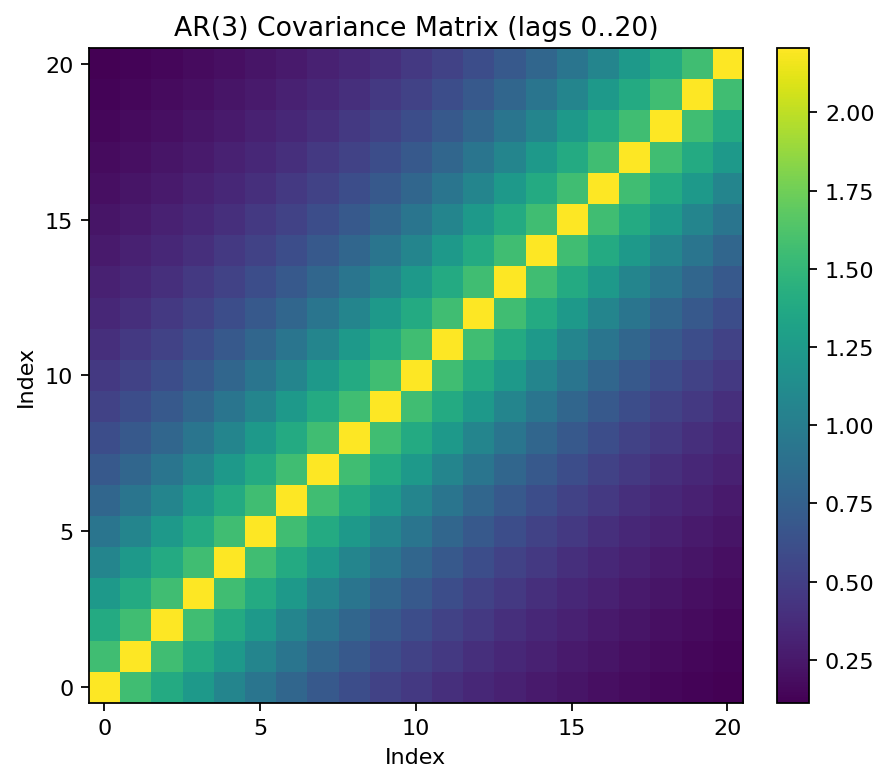

In [31]:
# Using the MAP estimates
phis_map = np.asarray(results[:3], dtype=float)
sigma_map = float(results[3])
max_h = 20

# 1) Compute covariance matrix up to lag 20
cov_twenty = ar_three_cov_matrix(phis_map, max_h=max_h, sigma_w=sigma_map)

# 2) Plot
fig, ax = plt.subplots(figsize=(6, 5), dpi=160)
im = ax.imshow(cov_twenty, origin='lower', interpolation='none')
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title('AR(3) Covariance Matrix (lags 0..20)')
ax.set_xlabel('Index')
ax.set_ylabel('Index')
ax.set_xticks([0, 5, 10, 15, 20])
ax.set_yticks([0, 5, 10, 15, 20])
plt.tight_layout()
plt.show()

The above heatmap is exactly what one would expect for a fitted AR(3):

- **Bright main diagonal** = variance γ(0) (largest entry).
- **Symmetric Toeplitz** look (constant along diagonals) because Γᵢⱼ = γ(|i − j|).
- **Smooth decay away from the diagonal** since the ACF of an AR process tails off rather than cutting off.  

The fitted φ’s evidently give a **monotone, non-oscillatory** decay, so no banding or checkerboard patterns appear.

What would look different for MA(3)?

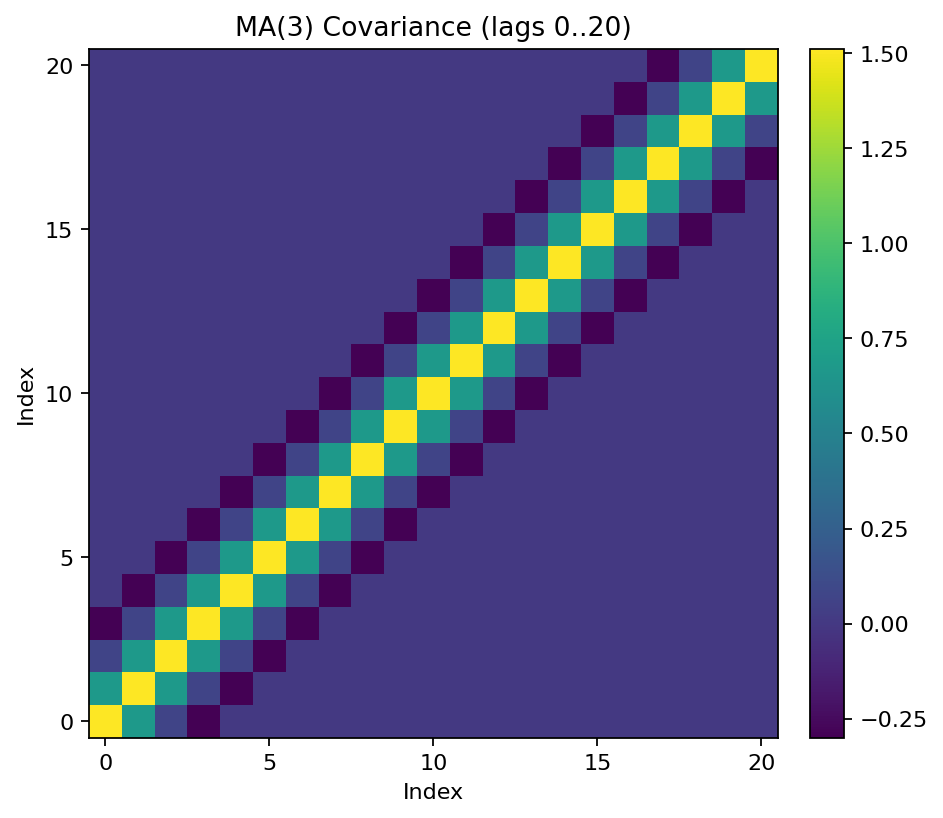

In [35]:
def ma_three_cov_matrix(thetas: np.ndarray, max_h: int, sigma_w: float) -> np.ndarray:
    """Covariance Γ for an MA(3) up to lag max_h"""
    thetas = np.asarray(thetas, dtype=float).ravel()
    if thetas.size != 3:
        raise ValueError("thetas must be length 3 for MA(3).")
    if max_h < 0:
        raise ValueError("max_h must be >= 0.")
    if sigma_w <= 0:
        raise ValueError("sigma_w must be > 0.")

    # Θ(B) = 1 + θ1 B + θ2 B^2 + θ3 B^3, AR(0): P(B) = 1
    ar_poly = np.array([1.0])
    ma_poly = np.r_[1.0, thetas]

    # Autocovariances γ(0..max_h)
    acv = arma_acovf(ar=ar_poly, ma=ma_poly, nobs=max_h + 1, sigma2=sigma_w**2)

    # Toeplitz covariance: Γ_{ij} = γ(|i-j|)
    idx  = np.arange(max_h + 1)
    cov  = acv[np.abs(idx[:, None] - idx[None, :])]
    return cov

# --- Example MA(3) parameters (invertible-ish), noise std ---
thetas_ma = np.array([0.6, 0.25, -0.3])
sigma_ma  = 1.0
max_h     = 20

cov_ma = ma_three_cov_matrix(thetas_ma, max_h=max_h, sigma_w=sigma_ma)

# Plot MA(3) 
fig, ax = plt.subplots(figsize=(6, 5), dpi=160, constrained_layout=True)

def _imshow(ax, M, title, vmin=None, vmax=None):
    im = ax.imshow(M, origin='lower', interpolation='none', vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel('Index'); ax.set_ylabel('Index')
    ax.set_xticks([0,5,10,15,20]); ax.set_yticks([0,5,10,15,20])
    return im

im = _imshow(ax, cov_ma, 'MA(3) Covariance (lags 0..20)')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.show()


The above heatmap is exactly what one would expect for an **MA(3)** process.

- **Banded matrix**: only the main diagonal and the next 3 off-diagonals on each side are non-zero (because γ(h) = 0 for |h| > q).
- **Symmetric Toeplitz**: constant along each diagonal and symmetric about the main diagonal.
- The dark area away from the band is (numerically) ~0.


Now we want the conditional distribution for the next m time steps given the past n. 

In [36]:
def conditioned_mean_covariance(mu_vec: np.ndarray, 
                                covariance_matrix: np.ndarray,
                                conditioned_observations: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Calculates the conditioned mean and covariance matrix of a multivariate 
    Gaussian.

    Args:
        mu_vec: Mean of distribution with length (n+m).
        covariance_matrix: Covariance matrix of the distribution with shape 
            (n+m * n+m).
        conditioned_observations: First n observations that are being 
            conditioned on.

    Returns:
        Mean and covariance of the next m observations.
    """

    n = conditioned_observations.shape[0]
    total_dim = mu_vec.shape[0]
    m = total_dim - n

    # Partition mean
    mu_x = mu_vec[:n]
    mu_y = mu_vec[n:]

    # Partition covariance matrix
    Σ_xx = covariance_matrix[:n, :n]
    Σ_yy = covariance_matrix[n:, n:]
    Σ_yx = covariance_matrix[n:, :n]
    Σ_xy = covariance_matrix[:n, n:]

    # Compute conditional mean: μ_y|x = μ_y + Σ_yx Σ_xx⁻¹ (x - μ_x)
    Σ_xx_inv = np.linalg.inv(Σ_xx)
    conditional_mean = mu_y + Σ_yx @ Σ_xx_inv @ (conditioned_observations - mu_x)

    # Compute conditional covariance: Σ_y|x = Σ_yy - Σ_yx Σ_xx⁻¹ Σ_xy
    conditional_covariance = Σ_yy - Σ_yx @ Σ_xx_inv @ Σ_xy

    return conditional_mean, conditional_covariance
    

With the conditioned mean and covariance we can now better understand our model’s fit. We want to do two things here:

1. **Do one-step-ahead prediction** using the previous 40 time steps to confirm that our model gives a reasonable fit to the data.  

2. **Predict the next 70 time steps** given the last 40 time steps in our signal (i.e., predict the future).

In [37]:
phis_map  = np.asarray(results[:3], dtype=float)
sigma_map = float(results[3])

# Initialize our mean and covariances for the one ahead.
one_ahead_start = len(signal) - 100
mu_one_ahead = np.zeros(len(signal) - one_ahead_start)
cov_one_ahead = np.zeros(len(signal) - one_ahead_start) 
n_lookback = 40

for time_step in range(one_ahead_start, len(signal)):
    past = signal[time_step - n_lookback: time_step]

    # Joint mean/cov for [past(40), next(1)]; mean is 0 for stationary AR
    mu_joint = np.zeros(n_lookback + 1)
    cov_joint = ar_three_cov_matrix(phis_map, max_h=n_lookback, sigma_w=sigma_map)

    # Condition on the first 40 to get the distribution of the next 1
    mu_cond, cov_cond = conditioned_mean_covariance(mu_joint, cov_joint, past)

    mu_one_ahead[time_step - one_ahead_start] = mu_cond[0]
    cov_one_ahead[time_step - one_ahead_start] = cov_cond[0,0]

In [38]:
# Predict the next 70 timesteps given the last 40.
predict_next = 70
n_lookback = 40
past = signal[-n_lookback:]

mu_joint = np.zeros(n_lookback + predict_next)
cov_joint = ar_three_cov_matrix(phis_map, max_h=n_lookback+predict_next-1, sigma_w=sigma_map)
mu_future, cov_future = conditioned_mean_covariance(mu_joint, cov_joint, past)

mu_total = np.concatenate([mu_one_ahead, mu_future])
var_total = np.concatenate([cov_one_ahead, np.diag(cov_future)])

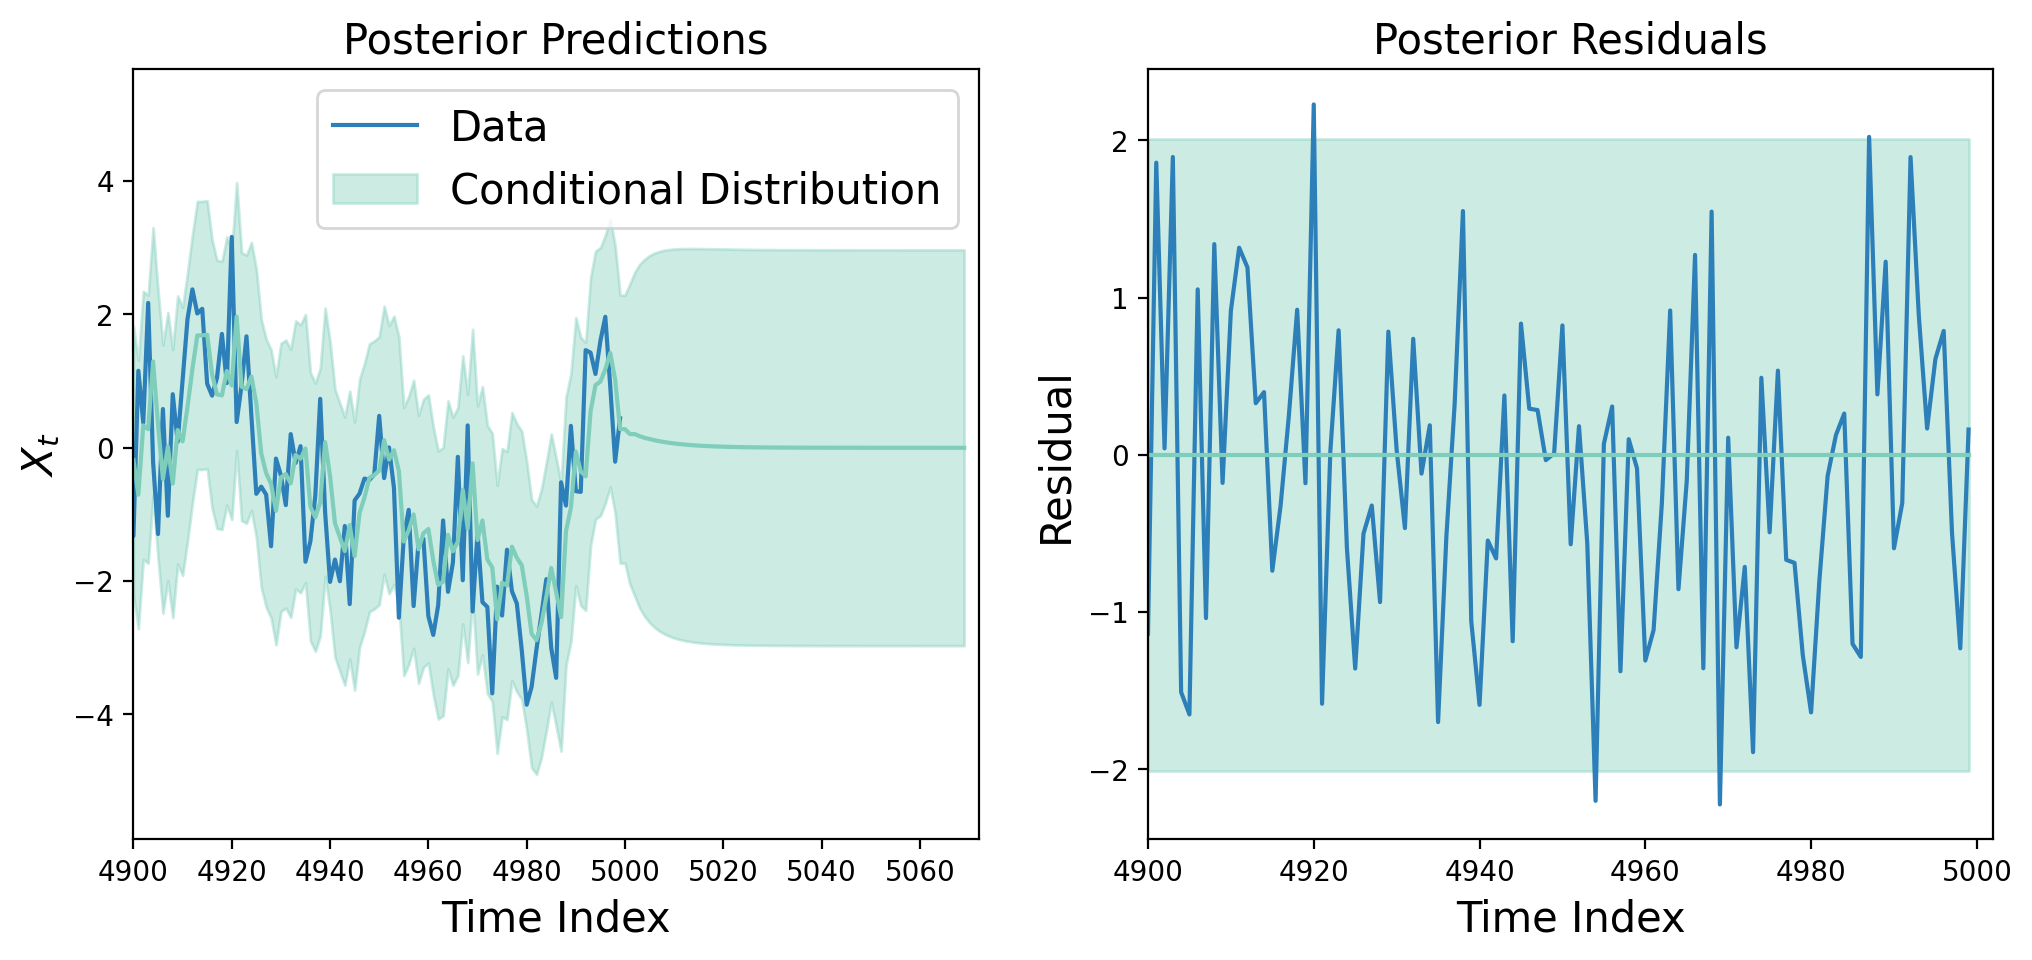

In [39]:
# Plot the result
colors = ['#7fcdbb', '#2c7fb8']
fontsize = 15
t_data = np.arange(len(signal))
t_cond = np.arange(one_ahead_start, len(signal))
t_total = np.arange(one_ahead_start, len(signal) + predict_next)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=200)
ax1.plot(t_data, signal, color=colors[1], label='Data')
ax1.plot(t_total, mu_total, color=colors[0])
ax1.fill_between(t_total, mu_total - 2 * np.sqrt(var_total), mu_total + 2 * np.sqrt(var_total),
                 color=colors[0], label=r'Conditional Distribution', alpha=0.4)

ax1.set_xlim([one_ahead_start, len(signal) + predict_next + 2])
ax1.set_ylabel(r'$X_t$', fontsize=fontsize)
ax1.set_xlabel('Time Index', fontsize=fontsize)
ax1.set_title('Posterior Predictions', fontsize=fontsize)
ax1.legend(fontsize=fontsize)

# Plot the residual.
ax2.plot(t_cond, signal[one_ahead_start:] - mu_one_ahead, color=colors[1], label='Data')
ax2.plot(t_cond, np.zeros(len(t_cond)), color=colors[0])
ax2.fill_between(t_cond,  -2 * np.sqrt(cov_one_ahead), 2 * np.sqrt(cov_one_ahead),
                 color=colors[0], label=r'Conditional Distribution', alpha=0.4)

ax2.set_xlim([one_ahead_start, len(signal) + 2])
ax2.set_ylabel(r'Residual', fontsize=fontsize)
ax2.set_xlabel('Time Index', fontsize=fontsize)
ax2.set_title('Posterior Residuals', fontsize=fontsize)

plt.show()

Yes, the plot matches the expectation. In the residual plot, almost all points stay inside the shaded ±2σ band and wobble around zero with no clear pattern. This means that the AR(3) model is making predictions that are consistent with the actual data, which in turn suggests that the model has captured the time-dependence (or pattern) in the data well and that its uncertainty estimates are reliable. What is left looks like white noise, as expected. A few outliers are expected with 95% bands. Overall, we have a good fit.

The posterior predictions plot also matches our expectations from a well-fitted AR(3) model. From time index 4900 to 5000, we observe one-step-ahead forecasts where the model uses only past data to predict the next point. These predictions closely track the observed data and remain within a narrow uncertainty band, indicating that the model has successfully captured the time-dependencies in the process. The forecast begins at time index 5001, using only the last 40 observed values (up to 5000), and extends 70 steps into the future. As expected, the mean predictions (green line) smoothly continue the observed pattern, while the prediction intervals (shaded region) widen over time, reflecting increased uncertainty as we forecast further ahead without new data. This growing variance is a natural and correct feature of multi-step forecasts. The initial predictions (e.g., step 1) are tightly concentrated, as they rely on the most recent data, but further steps accumulate uncertainty due to the propagation of noise and estimation error. As we predict further out, the forecasts gradually revert to the unconditional mean of zero, which is expected under a stationary AR process with zero-mean noise. Overall, the behavior of the forecast curve and its uncertainty band confirms that the model is behaving as a stable, stationary AR process, and is generating well-calibrated predictions.

In [40]:
# 95% coverage of one-step residuals
resid = signal[-100:] - mu_one_ahead
coverage = np.mean(np.abs(resid) <= 2*np.sqrt(cov_one_ahead))
print("Coverage (~0.95 expected):", coverage)

# First-step forecast variance equals innovation variance
print("cov_future[0,0] vs sigma_w^2:", cov_future[0,0], sigma_map**2)

# Long-horizon variance approaches γ(0)
gamma0 = ar_three_cov_matrix(phis_map, max_h=0, sigma_w=sigma_map)[0,0]
print("Last diag of cov_future vs γ(0):", np.diag(cov_future)[-1], gamma0)

Coverage (~0.95 expected): 0.96
cov_future[0,0] vs sigma_w^2: 1.011061306610502 1.0110613066105023
Last diag of cov_future vs γ(0): 2.204785855202744 2.2047858601707238


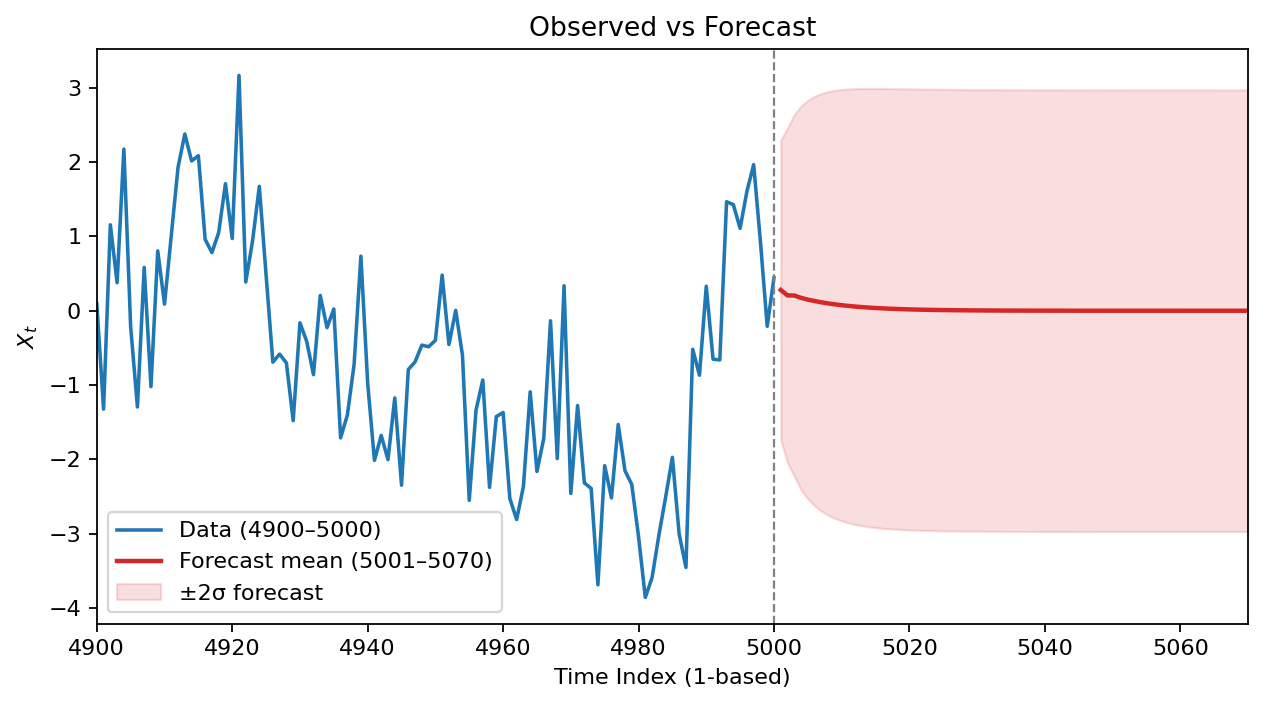

In [41]:
# Indices (1-based for labels)
start_obs_1b = 4900
end_obs_1b   = 5000  # last observed point (1-based)
pred_len     = 70    # 5001..5070

# Convert to 0-based array indices
obs_idx = np.arange(start_obs_1b - 1, end_obs_1b)      # 4899..4999
pred_idx = np.arange(len(signal), len(signal) + pred_len)  # 5000..5069

# x-axis values shown as 1-based
x_obs  = obs_idx + 1
x_pred = pred_idx + 1

fig, ax = plt.subplots(figsize=(8,4.5), dpi=160)
ax.plot(x_obs,  signal[obs_idx],  color='tab:blue', lw=1.6, label='Data (4900–5000)')
ax.plot(x_pred, mu_future,       color='tab:red',  lw=2.0, label='Forecast mean (5001–5070)')

# optional: add ±2σ band for the forecast
ax.fill_between(x_pred,
                mu_future - 2*np.sqrt(np.diag(cov_future)),
                mu_future + 2*np.sqrt(np.diag(cov_future)),
                color='tab:red', alpha=0.15, label='±2σ forecast')

# divider line at the boundary
ax.axvline(len(signal), color='gray', ls='--', lw=1)

ax.set_xlim(start_obs_1b, len(signal) + pred_len)
ax.set_xlabel('Time Index (1-based)')
ax.set_ylabel(r'$X_t$')
ax.set_title('Observed vs Forecast')
ax.legend()
plt.tight_layout()
plt.show()
